In [1]:
import json
import tensorflow as tf
import tensorflow_datasets as tfds

from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
!wget https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json

--2021-03-17 20:15:20--  https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6057046 (5.8M) [text/plain]
Saving to: ‘Sarcasm_Headlines_Dataset.json’

Sarcasm_Headlines_D 100%[===================>]   5.78M  --.-KB/s    in 0.04s   

2021-03-17 20:15:20 (129 MB/s) - ‘Sarcasm_Headlines_Dataset.json’ saved [6057046/6057046]



In [3]:
sentences =[]
labels = []

for line in open('Sarcasm_Headlines_Dataset.json', 'r').readlines():
  data = json.loads(line)
  sentences.append(data['headline'])
  labels.append(data['is_sarcastic'])

In [4]:
print(labels[:5], sentences[:5])

[1, 0, 0, 1, 1] ['thirtysomething scientists unveil doomsday clock of hair loss', 'dem rep. totally nails why congress is falling short on gender, racial equality', 'eat your veggies: 9 deliciously different recipes', 'inclement weather prevents liar from getting to work', "mother comes pretty close to using word 'streaming' correctly"]


In [5]:
x = []

sw = stopwords.words('english')

for sentence in sentences:
  sentence = sentence.lower()
  sentence = sentence.replace(",", " , ")
  sentence = sentence.replace(".", " . ")
  sentence = sentence.replace("-", " - ")
  sentence = sentence.replace("/", " / ")

  soup = BeautifulSoup(sentence)
  sentence = soup.get_text()

  words = sentence.split()
  filtered_sentence = ""

  for word in words:
    if word not in sw:
      filtered_sentence += word + " "
  x.append(filtered_sentence)

In [6]:
print(x[:5])
print(len(x))

['thirtysomething scientists unveil doomsday clock hair loss ', 'dem rep . totally nails congress falling short gender , racial equality ', 'eat veggies: 9 deliciously different recipes ', 'inclement weather prevents liar getting work ', "mother comes pretty close using word 'streaming' correctly "]
28619


In [7]:
training_size = 250000

x_train = x[:training_size]
y_train = labels[:training_size]

x_test = x[training_size:]
y_test = labels[training_size:]

In [8]:
vocab_size = 2500
maxlen = 18
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = tf.keras.preprocessing.sequence.pad_sequences(x_train_seq, padding='post', truncating=trunc_type, maxlen=maxlen)

OrderedDict([('new', 1658), ('trump', 1412), ('man', 1379), ('report', 604), ('one', 566), ('year', 541), ('day', 507), ('u', 506), ('area', 500), ('woman', 493), ('says', 484), ('donald', 473), ('time', 469), ('first', 467), ('like', 448), ('get', 423), ('old', 417), ("trump's", 403), ('life', 394), ('people', 392), ("'", 386), ('house', 379), ('still', 369), ('obama', 367), ('white', 366), ('back', 355), ('make', 351), ('women', 337), ('5', 315), ('clinton', 312), ('could', 311), ('world', 299), ('way', 296), ('americans', 288), ('family', 284), ('study', 277), ('would', 274), ('school', 263), ('gop', 262), ('black', 261), ('years', 259), ('bill', 257), ('finds', 252), ('really', 251), ('american', 248), ('best', 247), ('3', 247), ('last', 247), ('know', 245), ('police', 243), ('nation', 242), ("can't", 241), ('10', 238), ('going', 238), ('watch', 237), ('state', 235), ('death', 234), ('video', 230), ('home', 229), ('president', 228), ('good', 225), ('every', 224), ('say', 222), ('sh

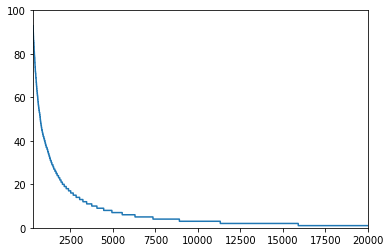

In [9]:
wc = tokenizer.word_counts
from collections import OrderedDict
from matplotlib import pyplot as plt
newlist = (OrderedDict(sorted(wc.items(), key=lambda t: t[1], reverse=True)))
print(newlist)

xs=[]
ys=[]
curr_x = 1
for item in newlist:
  xs.append(curr_x)
  curr_x=curr_x+1
  ys.append(newlist[item])
plt.plot(xs,ys)
plt.axis([300,20000,0,100])
plt.show()

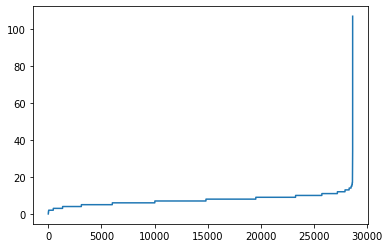

In [10]:
xs=[]
ys=[]
current_item=1
for item in x_train_seq:
  xs.append(current_item)
  current_item=current_item+1
  ys.append(len(item))
newys = sorted(ys)
import matplotlib.pyplot as plt
plt.plot(xs,newys)
plt.show()

In [11]:
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = tf.keras.preprocessing.sequence.pad_sequences(x_test_seq, padding='post', truncating=trunc_type, maxlen=maxlen)

In [12]:
embed_dim = 8 # Embed dim = 4th root of vocab size

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_dim), 
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.021)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.899, amsgrad=False)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 8)           20000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 20,081
Trainable params: 20,081
Non-trainable params: 0
_________________________________________________________________


In [13]:
import numpy as np
x_train_np = np.array(x_train_pad)
x_test_np = np.array(x_test_pad)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

In [14]:
history = model.fit(x_train_np,y_train_np, epochs=100, batch_size=32, validation_split=0.15)

Epoch 1/100
761/761 [==============================] - 6s 4ms/step - loss: 0.8550 - accuracy: 0.5314 - val_loss: 0.8103 - val_accuracy: 0.5316
Epoch 2/100
761/761 [==============================] - 2s 3ms/step - loss: 0.7979 - accuracy: 0.5442 - val_loss: 0.7643 - val_accuracy: 0.5427
Epoch 3/100
670/761 [=========================>....] - ETA: 0s - loss: 0.7566 - accuracy: 0.5586

KeyboardInterrupt: ignored

In [15]:
def plot(history):
  from matplotlib import pyplot as plt
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


In [ ]:
plot(history)

In [16]:
sentences = ["granny starting to fear spiders in the garden might be real",
"game of thrones season finale showing this sunday night",
"TensorFlow book will be a best seller"]

In [17]:
sequences = tokenizer.texts_to_sequences(sentences)
print(sequences)

[[1, 596, 1, 813, 1, 1, 1, 1, 273, 1, 112], [173, 1, 1, 174, 1, 2310, 1, 1539, 147], [1, 227, 1, 1, 1914, 47, 1]]


In [18]:
padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen,
                      padding=padding_type, truncating=trunc_type)
print(padded)

[[   1  596    1  813    1    1    1    1  273    1  112    0    0    0
     0    0    0    0]
 [ 173    1    1  174    1 2310    1 1539  147    0    0    0    0    0
     0    0    0    0]
 [   1  227    1    1 1914   47    1    0    0    0    0    0    0    0
     0    0    0    0]]


In [19]:
print(model.predict(padded))

[[0.49898592]
 [0.49129325]
 [0.4885289 ]]


**Visualizing Latent Space**

In [20]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

In [ ]:
print(reverse_word_index[2])
print(weights[2])

In [ ]:
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

**Using  Pre-Trained Embedding from TF-HUB**

In [ ]:
sentences =[]
labels = []

for line in open('Sarcasm_Headlines_Dataset.json', 'r').readlines():
  data = json.loads(line)
  sentences.append(data['headline'])
  labels.append(data['is_sarcastic'])

In [ ]:
training_size = 24000
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [ ]:
import tensorflow_hub as hub
hub_layer = hub.KerasLayer(
  "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1",
  output_shape=[20], input_shape=[],
  dtype=tf.string, trainable=False
)

In [ ]:
model2 = tf.keras.Sequential([
  hub_layer,
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model2.summary()

In [ ]:
history = model2.fit(training_sentences,training_labels, validation_data=(testing_sentences, testing_labels) , epochs=100, batch_size=32)

In [ ]:
plot(history)

**Using LSTM**

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 8)           20000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 20,625
Trainable params: 20,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
761/761 [==============================] - 6s 6ms/step - loss: 0.8934 - accuracy: 0.5242 - val_loss: 0.88

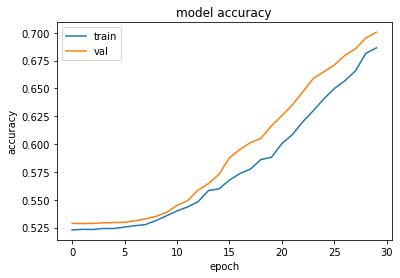

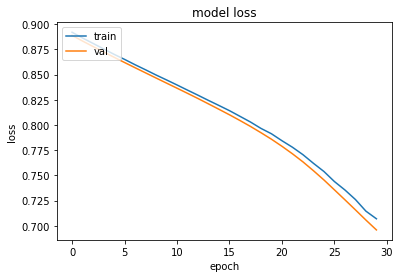

In [28]:
embed_dim = 8 # Embed dim = 4th root of vocab size

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_dim), 
    tf.keras.layers.LSTM(embed_dim, dropout=0.15),
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.021)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.000008, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()
history = model.fit(x_train_np,y_train_np, epochs=30, batch_size=32, validation_split=0.15)
plot(history)

**Using Bidirectional LSTM**

In [21]:
embed_dim = 8 # Embed dim = 4th root of vocab size

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_dim), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embed_dim)),
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.021)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.899, amsgrad=False)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 8)           20000     
_________________________________________________________________
bidirectional (Bidirectional (None, 16)                1088      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 21,233
Trainable params: 21,233
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(x_train_np,y_train_np, epochs=20, batch_size=32, validation_split=0.15)

Epoch 1/20
761/761 [==============================] - 6s 7ms/step - loss: 0.8685 - accuracy: 0.5289 - val_loss: 0.8244 - val_accuracy: 0.5278
Epoch 2/20
761/761 [==============================] - 5s 7ms/step - loss: 0.7890 - accuracy: 0.5475 - val_loss: 0.7560 - val_accuracy: 0.5521
Epoch 3/20
761/761 [==============================] - 5s 6ms/step - loss: 0.7303 - accuracy: 0.6061 - val_loss: 0.7057 - val_accuracy: 0.6352
Epoch 4/20
761/761 [==============================] - 6s 7ms/step - loss: 0.6874 - accuracy: 0.6532 - val_loss: 0.6665 - val_accuracy: 0.6916
Epoch 5/20
761/761 [==============================] - 5s 7ms/step - loss: 0.6516 - accuracy: 0.6840 - val_loss: 0.6295 - val_accuracy: 0.7063
Epoch 6/20
761/761 [==============================] - 5s 7ms/step - loss: 0.6138 - accuracy: 0.7146 - val_loss: 0.5940 - val_accuracy: 0.7279
Epoch 7/20
761/761 [==============================] - 5s 7ms/step - loss: 0.5823 - accuracy: 0.7349 - val_loss: 0.5643 - val_accuracy: 0.7452
Epoch 

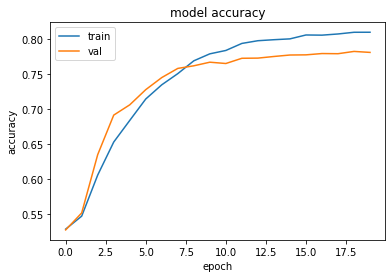

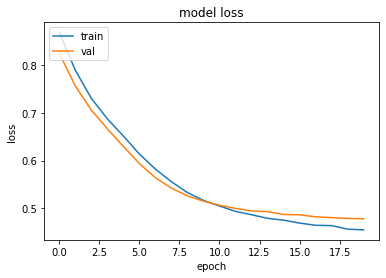

In [24]:
plot(history)

**Stacked LSTM**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 8)           20000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 16)          1088      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 16)                1600      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 22,833
Trainable params: 22,833
Non-trainable params: 0
__________________________________________________

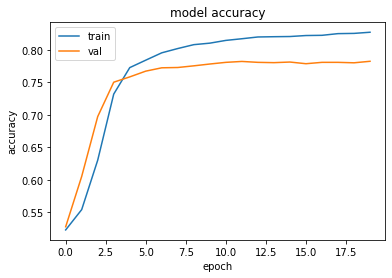

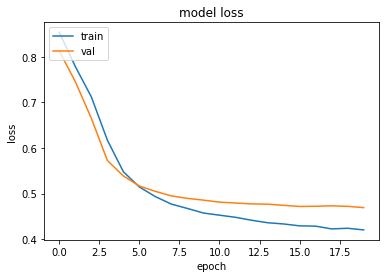

In [25]:
embed_dim = 8 # Embed dim = 4th root of vocab size

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_dim), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embed_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embed_dim)),
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.021)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.899, amsgrad=False)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()
history = model.fit(x_train_np,y_train_np, epochs=20, batch_size=32, validation_split=0.15)
plot(history)